## Get bounding boxes from parking lot images using YOLOv8n

In [1]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # load a pretrained YOLOv8n model

In [5]:
# Process all images from the "UFPR05" location, save bounding box centers, and plot them
import matplotlib.pyplot as plt
import os
#Specify the image directory
image_dir = "aligned_images/ufpr05_template_matching/"
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
print(f"Number of images: {len(os.listdir(image_dir))}")

Number of images: 1924


### Get YOLO results for all images

In [36]:
import cv2
import os

def process_images_with_yolo(image_files, model, save_annotated=False, output_dir="annotated_images", plot_centers=False):
    """
    Process images with YOLO, extract bounding box information, and optionally save annotated images.

    Args:
        image_files (list): List of image file paths to process.
        model (YOLO): YOLO model instance.
        save_annotated (bool): Whether to save annotated images. Default is False.
        output_dir (str): Directory to save annotated images if save_annotated is True. Default is "annotated_images".

    Returns:
        dict: Dictionary containing bounding box information for each image.
    """
    # Initialize a dictionary to store bounding box information
    bounding_box_infos = {}

    # Create output directory if saving annotated images
    if save_annotated:
        os.makedirs(output_dir, exist_ok=True)

    # Iterate through each image in the directory
    frame = -1
    for image_path in image_files:
        frame += 1

        # Run the image through the YOLO model
        results = model(image_path, verbose=False)

        # Access the first result
        result = results[0]

        # Extract bounding box information
        boxes = result.boxes  # Get the bounding boxes
        if boxes is not None:
            image_info = []  # List to store bounding box info for this image
            img = cv2.imread(image_path)  # Read the image for annotation

            for box in boxes:
                # Extract bounding box details
                center_x, center_y, width, height = box.xywh.tolist()[0]  # xywh format
                confidence = box.conf.tolist()[0]  # Confidence score
                class_id = int(box.cls.tolist()[0])  # Class ID
                label = result.names[class_id]  # Class label

                # Append the details as a dictionary
                image_info.append({
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height,
                    'confidence': confidence,
                    'label': label,
                    'frame': frame
                })

                # Annotate the image if saving
                if save_annotated:
                    top_left = (int(center_x - width / 2), int(center_y - height / 2))
                    bottom_right = (int(center_x + width / 2), int(center_y + height / 2))
                    cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)  # Draw bounding box
                    cv2.putText(img, f"{label} {confidence:.2f}", (top_left[0], top_left[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                # Plot the center of the bounding box
                if plot_centers:
                    center = (int(center_x), int(center_y))
                    cv2.circle(img, center, radius=3, color=(0, 0, 255), thickness=-1)  # Draw center point
            # Add the bounding box info for this image to the dictionary
            bounding_box_infos[os.path.basename(image_path)] = image_info

            # Save the annotated image
            if save_annotated:
                output_path = os.path.join(output_dir, os.path.basename(image_path))
                cv2.imwrite(output_path, img)

    return bounding_box_infos

bounding_box_infos = process_images_with_yolo(image_files, model)

In [ ]:
#Save bounding box information to a file
import json
with open('bounding_box_infos.json', 'w') as f:
    json.dump(bounding_box_infos, f, indent=4)

In [92]:
#Load from JSON file
with open('bounding_box_infos.json', 'r') as f:
    bounding_box_infos = json.load(f)

### Get summary statistics

In [8]:
from collections import Counter

# Initialize a Counter to store class counts
class_counts = Counter()

# Iterate through bounding_box_infos to count classes
for image_name, boxes in bounding_box_infos.items():
    for box in boxes:
        class_label = box['label']
        class_counts[class_label] += 1

# Print the detected classes and their counts
print("Detected Classes and Counts:")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count}")

Detected Classes and Counts:
car: 58070
person: 266
truck: 403
bus: 501
cell phone: 183
traffic light: 8
airplane: 24
boat: 8
potted plant: 11


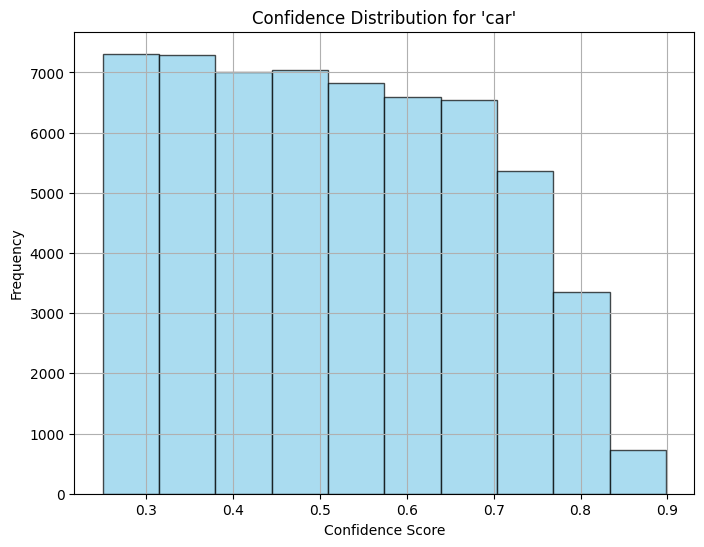

In [13]:
# Function to plot confidence distribution for a specific class
def plot_confidence_distribution(class_name):
    # Extract confidence scores for the specified class
    confidence_scores = [
        box['confidence']
        for boxes in bounding_box_infos.values()
        for box in boxes
        if box['label'] == class_name
    ]

    # Check if there are any instances of the class
    if confidence_scores:
        plt.figure(figsize=(8, 6))
        plt.hist(confidence_scores, bins=10, color='skyblue', edgecolor='k', alpha=0.7)
        plt.title(f"Confidence Distribution for '{class_name}'")
        plt.xlabel("Confidence Score")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
    else:
        print(f"No instances of class '{class_name}' found.")

# Example usage: Plot confidence distribution for the class "car"
plot_confidence_distribution("car")

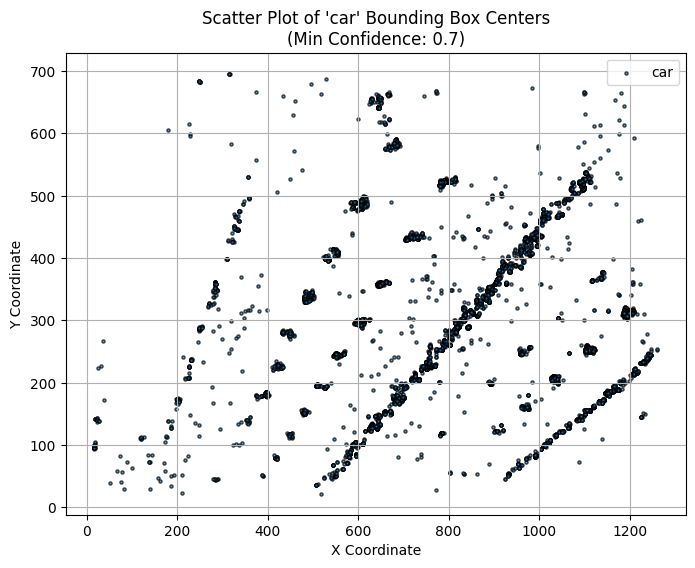

In [23]:
# Function to plot bounding box centers for a specific class with a minimum confidence score
def plot_class_scatter(class_name, min_confidence=0.0):
    # Extract centers for the specified class with confidence >= min_confidence
    class_centers = [
        (box['center_x'], box['center_y'])
        for boxes in bounding_box_infos.values()
        for box in boxes
        if box['label'] == class_name and box['confidence'] >= min_confidence
    ]

    # Check if there are any instances of the class
    if class_centers:
        x_coords, y_coords = zip(*class_centers)
        plt.figure(figsize=(8, 6))
        plt.scatter(x_coords, y_coords, alpha=0.7, s=5, edgecolors='k', label=class_name)
        plt.title(f"Scatter Plot of '{class_name}' Bounding Box Centers\n(Min Confidence: {min_confidence})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No instances of class '{class_name}' found with confidence >= {min_confidence}.")
        
plot_class_scatter("car", min_confidence=0.7)

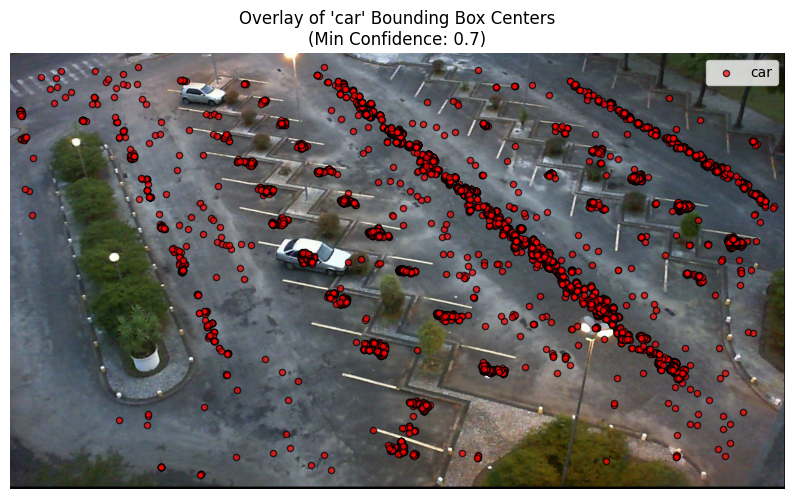

In [31]:
# Function to overlay bounding box centers on a parking lot image
def plot_class_scatter_overlay(image_path, class_name, min_confidence=0.0):
    # Extract centers for the specified class with confidence >= min_confidence
    class_centers = [
        (box['center_x'], box['center_y'])
        for boxes in bounding_box_infos.values()
        for box in boxes
        if box['label'] == class_name and box['confidence'] >= min_confidence
    ]

    # Check if there are any instances of the class
    if class_centers:
        x_coords, y_coords = zip(*class_centers)

        # Load the parking lot image
        img = plt.imread(image_path)

        # Plot the image as the background
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.scatter(x_coords, y_coords, alpha=0.7, s=20, edgecolors='k', label=class_name, color='red')
        plt.title(f"Overlay of '{class_name}' Bounding Box Centers\n(Min Confidence: {min_confidence})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.axis('off')  # Turn off axes for better visualization
        plt.show()
    else:
        print(f"No instances of class '{class_name}' found with confidence >= {min_confidence}.")

background_image_path = "aligned_images/ufpr05_template_matching/2013-02-22_06_05_00.jpg"
# Overlay the scatter plot for the class "car" with a minimum confidence of 0.7
plot_class_scatter_overlay(background_image_path, "car", min_confidence=0.7)

## Filtering and heuristics

Apply some logic to filter out points that appear for one frame only, to remove cars-in-transit.  Parked cars should remain stationary (i.e. bounding box center moving only within small margin) for more than one image.

In [ ]:
import math
from collections import defaultdict

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to process the JSON data with min_persistence and organize by frame
def process_json_data(data, label, confidence_threshold, radius, min_persistence):
    # Step 1: Filter data by label and confidence threshold, and organize by frame
    points_by_frame = defaultdict(list)
    for image, detections in data.items():
        for detection in detections:
            # Extract only relevant fields and filter by label and confidence
            if detection["label"] == label and detection["confidence"] >= confidence_threshold:
                points_by_frame[detection["frame"]].append((detection["center_x"], detection["center_y"]))
    
    # Convert to a sorted list of frames
    max_frame = max(points_by_frame.keys(), default=-1)  # Handle empty data gracefully
    organized_data = [points_by_frame[frame] for frame in range(max_frame + 1)]
        
    # Step 2: Compare points across frames with persistence
    matching_points = set()  # Use a set to avoid duplicates
    for i, current_points in enumerate(organized_data):
        for point in current_points:
            persistence_count = 1  # Start with the current frame
            cluster = {point}  # Track the cluster of matching points

            # Check consecutive frames forward
            for j in range(1, min_persistence):
                if i + j < len(organized_data):  # Ensure we don't go out of bounds
                    found_match = False
                    for next_point in organized_data[i + j]:
                        if euclidean_distance(point, next_point) <= radius:
                            cluster.add(next_point)
                            found_match = True
                            break
                    if found_match:
                        persistence_count += 1
                    else:
                        break  # Stop checking if no match is found

            # Check consecutive frames backward
            for j in range(1, min_persistence):
                if i - j >= 0:  # Ensure we don't go out of bounds
                    found_match = False
                    for prev_point in organized_data[i - j]:
                        if euclidean_distance(point, prev_point) <= radius:
                            cluster.add(prev_point)
                            found_match = True
                            break
                    if found_match:
                        persistence_count += 1
                    else:
                        break  # Stop checking if no match is found

            # If the point persists for the required number of frames, add the cluster
            if persistence_count >= min_persistence:
                matching_points.update(cluster)

    # Step 3: Return the matching points as a list
    return list(matching_points)

In [101]:
for p in matches_by_persistence:
    print(len(p))

99
99
99
99
99


In [104]:
label = "car"
confidence_threshold = 0.8

matches_by_persistence = []
for persistence in range(1, 6):
    n_matches = []
    for radius in range(1, 10):
        matching_points = process_json_data(bounding_box_infos, label, confidence_threshold, radius, min_persistence=persistence)
        n_matches.append(len(matching_points))
    matches_by_persistence.append(n_matches)

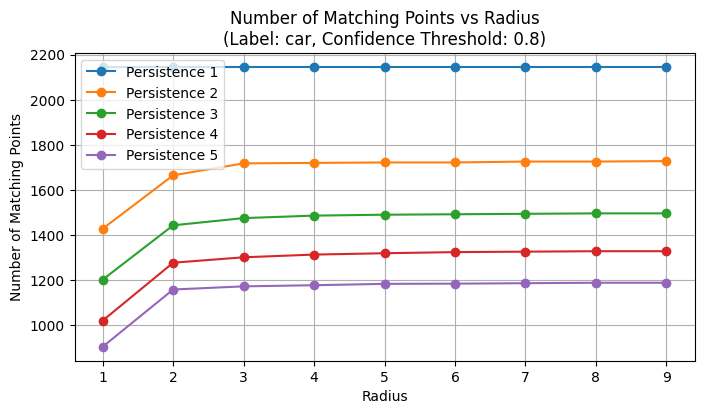

In [108]:
# Plot number of matches vs radius for each persistence value
plt.figure(figsize=(8, 4))
for persistence, n_matches in enumerate(matches_by_persistence, start=1):
    plt.plot(range(1, 10), n_matches, marker='o', label=f'Persistence {persistence}')
plt.title(f"Number of Matching Points vs Radius\n(Label: {label}, Confidence Threshold: {confidence_threshold})")
plt.xlabel("Radius")
plt.ylabel("Number of Matching Points")
plt.grid(True)
plt.legend()
plt.show()

In [128]:
#Overlay matching points on parking lot image
def plot_matching_points_overlay(image_path, matching_points, radius, persistence, label, confidence_threshold):
    # Load the parking lot image
    img = plt.imread(image_path)

    # Plot the image as the background
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    if matching_points:
        x_coords, y_coords = zip(*matching_points)
        plt.scatter(x_coords, y_coords, alpha=0.7, s=20, edgecolors='k', label='Matching Points', color='red')
    
    plt.title(f"Overlay of Matching Points\n(Label: {label}, Radius: {radius}, Persistence: {persistence}, Confidence Threshold: {confidence_threshold})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    #plt.legend()
    plt.axis('off')  # Turn off axes for better visualization
    plt.show()


## Create background image with median filtering

Median image saved to median_image.jpg


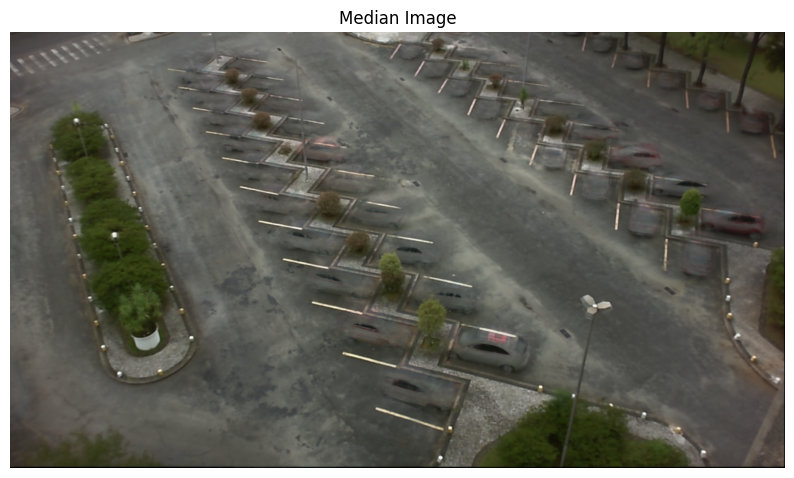

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory containing the aligned images
median_dir = "aligned_images/ufpr05_template_matching/"
image_files = sorted([os.path.join(median_dir, f) for f in os.listdir(median_dir) if f.endswith('.jpg')])

# Load all images into a list
images = []
for file in image_files:
    img = cv2.imread(file)  # Read the image
    if img is not None:
        images.append(img)

# Ensure there are images to process
if len(images) == 0:
    print("No images found in the directory.")
else:
    # Stack images into a 4D numpy array (num_images, height, width, channels)
    image_stack = np.stack(images, axis=0)


In [ ]:
# Compute the median along the first axis (across all images)
median_image = np.median(image_stack, axis=0).astype(np.uint8)

# Save the median image
output_path = "median_image.jpg"
cv2.imwrite(output_path, median_image)
print(f"Median image saved to {output_path}")

# Display the median image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(median_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Median Image")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `image_stack` is already computed
# image_stack shape: (num_images, height, width, channels)

# Get the dimensions of the image stack
num_images, height, width, channels = image_stack.shape

# Initialize an empty array for the mode image
mode_image = np.zeros((height, width, channels), dtype=np.uint8)

# Iterate through each pixel and compute the mode
for y in range(height):
    for x in range(width):
        for c in range(channels):
            # Extract the pixel values across all images for this location
            pixel_values = image_stack[:, y, x, c]
            
            # Count the occurrences of each value and find the mode
            mode_value = Counter(pixel_values).most_common(1)[0][0]
            
            # Assign the mode value to the mode image
            mode_image[y, x, c] = mode_value

# Save the mode image
output_path = "mode_image_brute_force.jpg"
cv2.imwrite(output_path, mode_image)
print(f"Mode image saved to {output_path}")

# Display the mode image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(mode_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Mode Image (Brute Force)")
plt.axis("off")
plt.show()

# Print the shape of the mode image
print("Mode image shape:", mode_image.shape)

In [137]:
#shape of mode image
print("Mode image shape:", mode_image.shape)

Mode image shape: (1280, 3)


In [124]:
label = "car"
confidence_threshold = 0.5
radius = 2
persistence = 5

matching_points = process_json_data(bounding_box_infos, label, confidence_threshold, radius, min_persistence=persistence)
print("Matching Points:", len(matching_points))

Matching Points: 19715


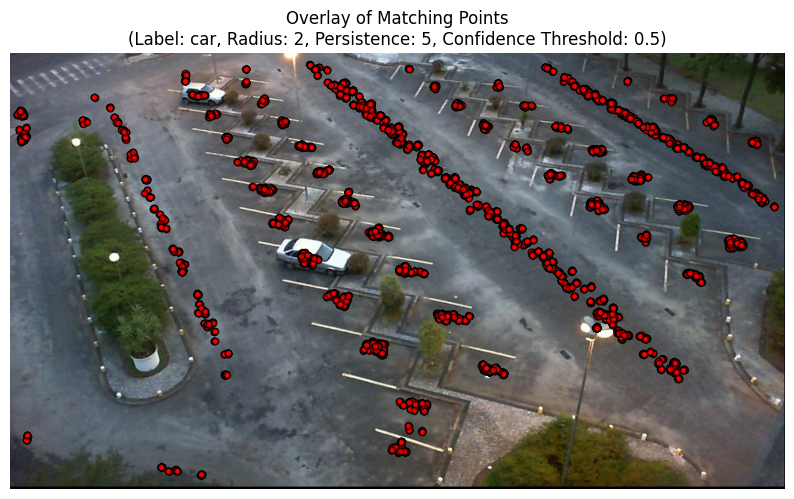

In [129]:
background_image_path = "aligned_images/ufpr05_template_matching/2013-02-22_06_05_00.jpg"
# Overlay the matching points on the parking lot image
plot_matching_points_overlay(background_image_path, matching_points, radius, persistence, label, confidence_threshold)

### Potted plant investigation

In [ ]:
label = "potted plant"
confidence_threshold = 0.1
radius = 2
persistence = 1

matching_points = process_json_data(bounding_box_infos, label, confidence_threshold, radius, min_persistence=persistence)
print("Matching Points:", len(matching_points))

Matching Points: 183


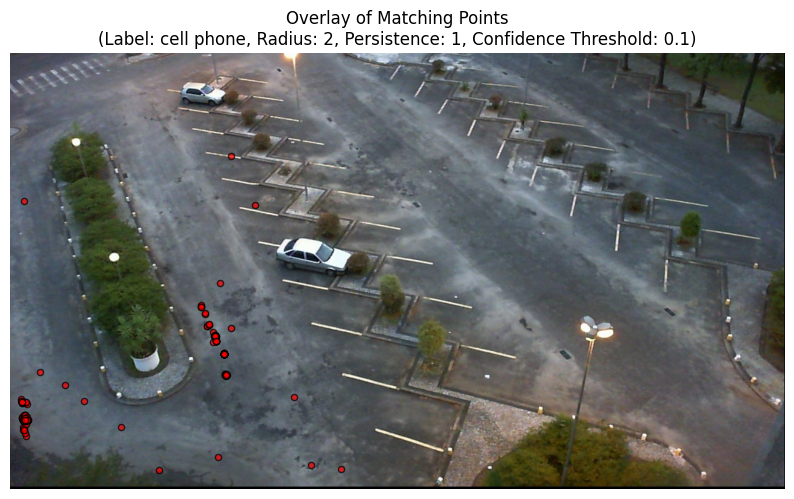

In [133]:
background_image_path = "aligned_images/ufpr05_template_matching/2013-02-22_06_05_00.jpg"
# Overlay the matching points on the parking lot image
plot_matching_points_overlay(background_image_path, matching_points, radius, persistence, label, confidence_threshold)